In [30]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, explained_variance_score, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from scipy.stats import skew, norm, probplot

df = pd.read_csv('data/real_estate_belguim.csv', sep=',') 

# Decision tree + Random Forest

In [31]:
df.shape

(23963, 21)

In [32]:
df.head(10)

,price,postal_code,longitude,latitude,region,province,municipality,crime_rate,population_km,prosperity_index,...,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,number_of_facades,swimming_pool,exterior_space,accessible
0,289000.0,8680,51.090212,2.972217,région flamande,flandre occidentale (la),koekelare,10.055527,223.812277,98.0,...,3,3.0,120.0,0,0.0,0,1.0,0.0,1,1
1,259000.0,5030,50.562261,4.697015,région wallonne,namur,gembloux,17.729898,274.633658,110.0,...,2,3.0,154.0,0,0.0,0,4.0,0.0,1,0
2,429210.0,9052,51.003447,3.708325,région flamande,flandre orientale (la),gent,45.408517,1708.806368,103.0,...,2,2.0,100.0,1,0.0,0,3.0,0.0,1,1
3,314000.0,1770,50.866522,4.093036,région flamande,brabant flamand (le),liedekerke,25.270628,1377.249099,103.0,...,3,2.0,96.0,1,0.0,0,4.0,0.0,1,1
4,229000.0,2500,51.131602,4.561792,région flamande,antwerpen,lier,21.221750,766.455003,109.0,...,2,2.0,105.0,0,0.0,0,2.0,0.0,0,0
5,359000.0,9300,50.941781,4.047008,région flamande,flandre orientale (la),aalst,17.729898,1156.875981,105.0,...,3,3.0,122.0,0,0.0,0,2.0,0.0,1,0
6,260000.0,9620,50.868935,3.790569,région flamande,flandre orientale (la),zottegem,17.729898,488.761973,116.0,...,2,3.0,219.0,0,0.0,0,3.0,0.0,0,0
7,375000.0,1440,50.678788,4.268278,région wallonne,brabant wallon (le),braine-le-château,13.889408,467.972994,116.0,...,3,2.0,124.0,0,0.0,0,2.0,0.0,1,1
8,340000.0,2150,51.191459,4.487687,région flamande,antwerpen,borsbeek,2.119141,2666.254939,87.0,...,1,4.0,270.0,0,0.0,0,2.0,0.0,0,0
9,345000.0,8200,51.193722,3.170873,région flamande,flandre occidentale (la),brugge,29.267071,850.208400,110.0,...,2,2.0,81.0,0,0.0,0,2.0,0.0,0,0


* Apply log1p transformation to 'price' column

In [33]:
# Numerical features and categorical features
categorical_features = df.select_dtypes(include = ["object"]).columns
numerical_features = df.select_dtypes(exclude=["object"]).drop("price", axis=1).columns

df_numerical = df[numerical_features]
df_categorical = df[categorical_features]

print("Numerical features: " + str(len(numerical_features)))
print("Categorical features: " + str(len(categorical_features)))

Numerical features: 16
Categorical features: 4


In [34]:
# Find skewed features
df_numerical = df_numerical.astype(np.float64)
skewness = df_numerical.apply(lambda x: skew(x, nan_policy='omit'))
skewed_features = skewness[abs(skewness) > 0.5].index

print(f"Skewed numerical features: {len(skewed_features)}")

# Log transform the skewed numerical features 
#df_numerical[skewed_features] = df_numerical[skewed_features].apply(np.log1p)

Skewed numerical features: 10


In [35]:
# Concatenate categorical_features and numerical
categorical_features_df = df[categorical_features]
complete_features = pd.concat([df_numerical, categorical_features_df], axis=1)
complete_features.shape

(23963, 20)

In [36]:
# Apply OneHotEncoding to the categorical features
#encoder = OneHotEncoder(drop='first', sparse_output=False)  
#categorical_encoded = encoder.fit_transform(df_categorical)

# Convert the encoded features into a DataFrame
#encoded_df = pd.DataFrame(categorical_encoded, columns=encoder.get_feature_names_out(categorical_features))

# Concatenate the numerical features with the encoded categorical features
#complete_features = pd.concat([df_numerical, encoded_df], axis=1)

#df = pd.concat([complete_features, df['price']], axis = 1)

In [37]:
#complete_features_dummies = pd.get_dummies(complete_features,drop_first=True)
#df = pd.concat([complete_features_dummies, df['price']], axis = 1)

In [38]:
# Ordinal encoding for categorical features (random as these columns has no real order)
for column in categorical_features_df :
    unique_categories = complete_features[column].unique()
    np.random.shuffle(unique_categories)  
    category_map = {category: idx for idx, category in enumerate(unique_categories)}
    complete_features[column] = complete_features[column].map(category_map)

#Add 'price' columns
df = pd.concat([complete_features, df['price']], axis=1)
df = pd.concat([complete_features, df['price']], axis=1)

In [39]:
df

,postal_code,longitude,latitude,crime_rate,population_km,prosperity_index,state_of_the_building,number_of_rooms,living_area,fully_equipped_kitchen,...,open_fire,number_of_facades,swimming_pool,exterior_space,accessible,region,province,municipality,type_of_property,price
0,8680.0,51.090212,2.972217,10.055527,223.812277,98.0,3.0,3.0,120.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0,5,483,1,289000.0
1,5030.0,50.562261,4.697015,17.729898,274.633658,110.0,2.0,3.0,154.0,0.0,...,0.0,4.0,0.0,1.0,0.0,2,4,239,0,259000.0
2,9052.0,51.003447,3.708325,45.408517,1708.806368,103.0,2.0,2.0,100.0,1.0,...,0.0,3.0,0.0,1.0,1.0,0,9,258,1,429210.0
3,1770.0,50.866522,4.093036,25.270628,1377.249099,103.0,3.0,2.0,96.0,1.0,...,0.0,4.0,0.0,1.0,1.0,0,6,304,1,314000.0
4,2500.0,51.131602,4.561792,21.221750,766.455003,109.0,2.0,2.0,105.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0,7,50,0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23958,2861.0,51.059134,4.575467,13.889408,602.732409,116.0,3.0,1.0,56.0,1.0,...,0.0,3.0,0.0,1.0,1.0,0,7,224,1,179000.0
23959,6900.0,50.212491,5.366233,25.270628,147.224385,94.0,2.0,3.0,129.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2,8,400,1,249000.0
23960,3130.0,50.995022,4.785669,10.055527,601.241474,117.0,2.0,4.0,213.0,1.0,...,0.0,3.0,0.0,0.0,0.0,0,6,198,0,579500.0
23961,8450.0,51.236712,2.977378,25.270628,1275.613931,106.0,3.0,3.0,201.0,0.0,...,0.0,2.0,0.0,1.0,0.0,0,5,358,0,429000.0


***

In [40]:
X = df.drop('price', axis=1)
y = df['price'].values.reshape(-1,1)

print("x:", X.shape)
print("y:", y.shape)

scalar = StandardScaler()
x_transform = scalar.fit_transform(X)

x:

 (23963, 20)
y: (23963, 1)


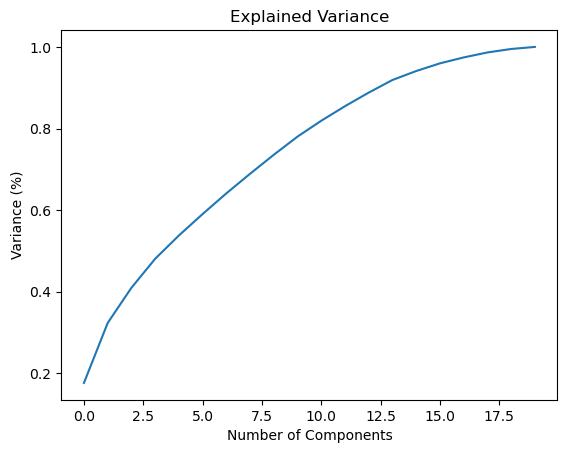

In [41]:

pca = PCA()
principalComponents = pca.fit_transform(x_transform)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Explained Variance')
plt.show()

In [ ]:
pca = PCA(n_components=7)
new_data = pca.fit_transform(x_transform)
principal_x = pd.DataFrame(new_data,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7'])

principal_x

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8
0,2.212057,-0.929615,-0.691837,0.320951,0.630540,0.716781,1.879836,-0.376162
1,-2.553275,0.380450,-1.120985,0.375117,-0.210426,-0.121791,0.103581,-0.348392
2,2.387303,-0.182537,0.277304,1.172399,1.752687,-0.171698,0.064623,-0.219145
3,1.441753,0.481571,-0.251465,3.212959,0.192171,-0.665434,0.249524,-0.018361
4,0.247962,-0.509266,0.293698,-0.718219,-1.075932,-1.389661,-1.448406,0.566152
...,...,...,...,...,...,...,...,...
23958,2.345231,-0.019227,-1.089618,3.313559,-0.353836,-1.103477,-0.228599,-0.202355
23959,-1.268605,1.457564,-1.027202,-0.735251,-0.618738,-0.772907,0.398057,0.543354
23960,-1.758171,-1.574298,0.848778,1.530929,-0.137667,-1.646404,-0.109345,0.889197
23961,0.089528,-1.705626,0.751225,-0.174716,1.255293,0.388146,1.225577,0.053344


In [43]:
X_train, X_test, y_train, y_test = train_test_split(x_transform, y, test_size=0.2, random_state=355)

In [44]:
clf = RandomForestRegressor(random_state=200)
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

/opt/anaconda3/envs/immo-eliza/lib/python3.11/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.6605649446982876

In [ ]:
# we are tuning three hyperparameters right now, we are passing the different values for both parameters
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 50, 100, None],  
    'min_samples_leaf': [1, 5, 10, 20],  
    'min_samples_split': [2, 5, 10, 20],  
}

grid_search = GridSearchCV(estimator=clf,param_grid=grid_param,cv=5,n_jobs =-1)

grid_search.fit(X_train,y_train)

In [ ]:
best_parameters = grid_search.best_params_
print(best_parameters)

In [ ]:
grid_search.best_score_

In [ ]:
#clf_ = RandomForestRegressor(random_state=287)
#clf_.fit(X_train,y_train)

In [ ]:
# Evaluation metrics

# Explained Variance Score
# Evaluates how much variance in y_test is explained by the predictions (pred_tr).
#Unlike R², this metric focuses on the variance explained without penalizing the model for bias.
expl_tr = explained_variance_score(y_pred_tr_regressor,y_test)
print(f'Explained Variance Score: {expl_tr}')

# RMSE (Root Mean Square Error)
rmse_ = root_mean_squared_error(y_test, y_pred_tr_regressor)
print("\nRMSE: ", rmse_)

# MAE (Mean absolute error)
mae_ = mean_absolute_error(y_test, y_pred_tr_regressor)
print("MAE: ", mae_)

# Accurancy
print('Accuracy on training set: {:3f}'.format(tr_regressor.score(X_train,y_train)))
print('Accuracy on test set: {:3f}'.format(tr_regressor.score(X_test,y_test)))